<a href="https://colab.research.google.com/github/fmurital/Optimizing-Buckets-Default-Rates-by-FICO-Bucketing/blob/main/FICO_Score_Bucketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optimal Boundaries (MSE): [408, np.int64(552), np.int64(606), np.int64(654), np.int64(705), 851]
Optimal Boundaries (Log-Likelihood): [408, np.int64(510), np.int64(553), np.int64(615), np.int64(676), 851]


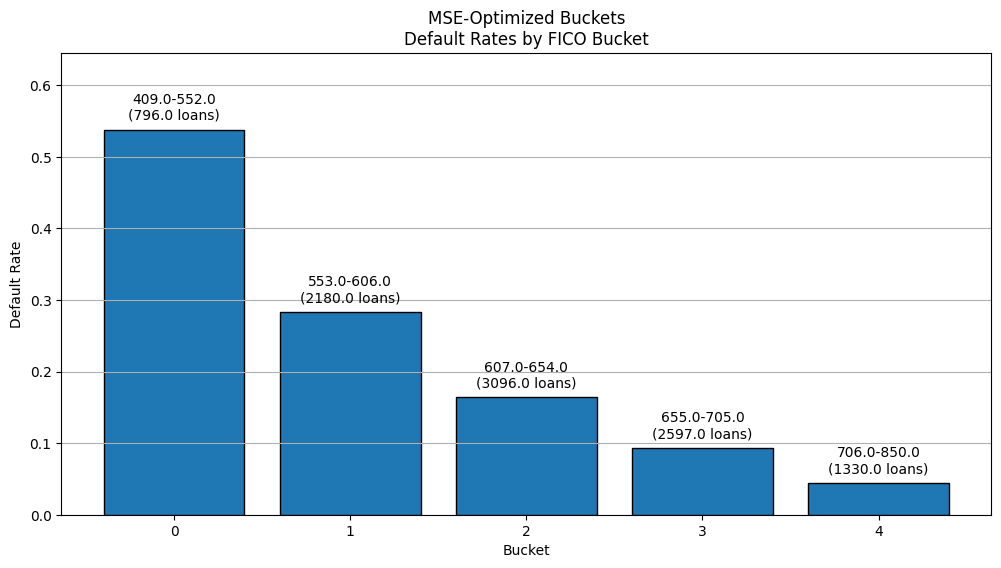

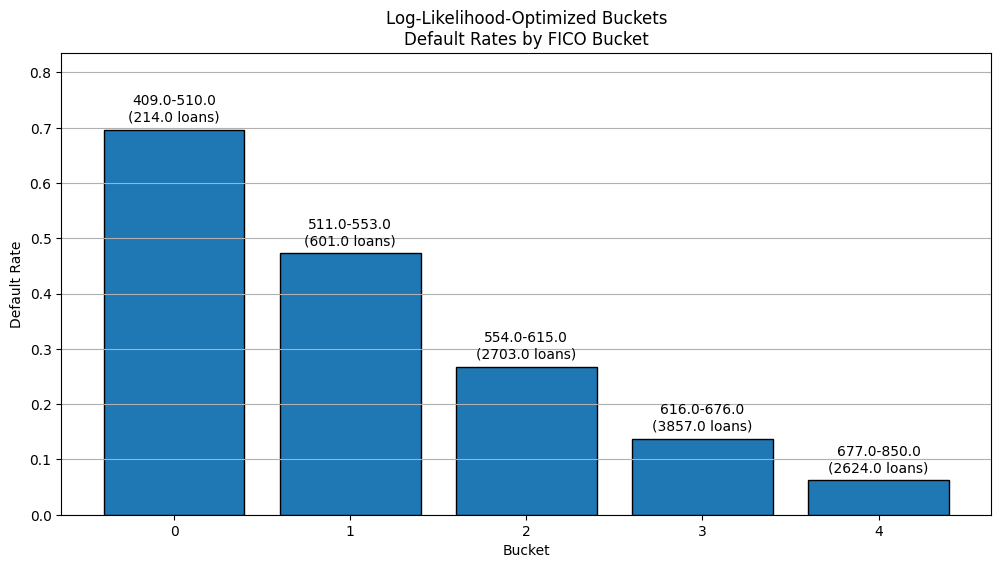


MSE-Optimized Rating Map:
   rating    range
0       5  408-551
1       4  552-605
2       3  606-653
3       2  654-704
4       1  705-851

Log-Likelihood-Optimized Rating Map:
   rating    range
0       5  408-509
1       4  510-552
2       3  553-614
3       2  615-675
4       1  676-851

Example Bucketing (Log-Likelihood):
FICO 450: Bucket 0, Rating 5
FICO 580: Bucket 2, Rating 3
FICO 650: Bucket 3, Rating 2
FICO 720: Bucket 4, Rating 1
FICO 780: Bucket 4, Rating 1
FICO 820: Bucket 4, Rating 1

Method Comparison:
MSE-Optimized Buckets:
Average bucket size: 1999.8
Default rate range: 0.0444-0.5377

Log-Likelihood-Optimized Buckets:
Average bucket size: 1999.8
Default rate range: 0.0625-0.6963


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from itertools import combinations

# Load the data
data = pd.read_csv('Task_3_and_4_Loan_Data.csv')

## Helper Functions

def calculate_mse_loss(boundaries, scores, values):
    """
    Calculate mean squared error for given bucket boundaries
    """
    buckets = pd.cut(scores, bins=boundaries, labels=False)
    bucket_means = values.groupby(buckets).mean()
    mse = ((values - bucket_means[buckets].values) ** 2).mean()
    return mse

def calculate_log_likelihood(boundaries, scores, defaults):
    """
    Calculate log-likelihood for given bucket boundaries
    """
    buckets = pd.cut(scores, bins=boundaries, labels=False)
    grouped = defaults.groupby(buckets).agg(['count', 'sum'])
    ni = grouped['count']
    ki = grouped['sum']
    pi = ki / ni

    # Handle cases where pi=0 or pi=1 for log calculations
    pi = np.clip(pi, 1e-10, 1-1e-10)

    log_likelihood = (ki * np.log(pi) + (ni - ki) * np.log(1 - pi)).sum()
    return -log_likelihood  # Return negative for minimization

def find_optimal_boundaries(scores, defaults, n_buckets=5, method='mse'):
    """
    Find optimal bucket boundaries using specified method
    """
    # Sort scores and get unique values
    sorted_scores = np.sort(scores.unique())

    # Generate possible boundary combinations
    min_score, max_score = scores.min(), scores.max()
    possible_splits = sorted_scores[1:-1]  # Exclude min and max

    # Dynamic programming approach
    memo = {}

    def dp(start_idx, end_idx, remaining_buckets):
        if (start_idx, end_idx, remaining_buckets) in memo:
            return memo[(start_idx, end_idx, remaining_buckets)]

        if remaining_buckets == 1:
            score_slice = scores[(scores >= sorted_scores[start_idx]) &
                               (scores <= sorted_scores[end_idx])]
            default_slice = defaults[(scores >= sorted_scores[start_idx]) &
                                   (scores <= sorted_scores[end_idx])]

            if method == 'mse':
                val = score_slice.mean()
                loss = ((score_slice - val) ** 2).sum()
            else:  # log-likelihood
                k = default_slice.sum()
                n = len(default_slice)
                p = max(min(k / n, 1-1e-10), 1e-10)
                loss = -(k * np.log(p) + (n - k) * np.log(1 - p))

            memo[(start_idx, end_idx, remaining_buckets)] = (loss, [])
            return (loss, [])

        min_loss = float('inf')
        best_splits = []

        for split_idx in range(start_idx + 1, end_idx - remaining_buckets + 2):
            left_loss, left_splits = dp(start_idx, split_idx, 1)
            right_loss, right_splits = dp(split_idx, end_idx, remaining_buckets - 1)

            total_loss = left_loss + right_loss
            if total_loss < min_loss:
                min_loss = total_loss
                best_splits = [sorted_scores[split_idx]] + right_splits

        memo[(start_idx, end_idx, remaining_buckets)] = (min_loss, best_splits)
        return (min_loss, best_splits)

    # Run DP algorithm
    total_loss, optimal_splits = dp(0, len(sorted_scores) - 1, n_buckets)

    # Create full boundaries
    boundaries = [min_score] + sorted(optimal_splits) + [max_score + 1]  # +1 to include max score
    return boundaries

## Implementation

# Prepare data
scores = data['fico_score']
defaults = data['default']

# Find optimal boundaries using both methods
mse_boundaries = find_optimal_boundaries(scores, defaults, n_buckets=5, method='mse')
ll_boundaries = find_optimal_boundaries(scores, defaults, n_buckets=5, method='loglikelihood')

print("Optimal Boundaries (MSE):", mse_boundaries)
print("Optimal Boundaries (Log-Likelihood):", ll_boundaries)

## Visualization

def plot_buckets(boundaries, scores, defaults, title):
    data['bucket'] = pd.cut(scores, bins=boundaries, labels=False)
    bucket_stats = data.groupby('bucket').agg(
        min_score=('fico_score', 'min'),
        max_score=('fico_score', 'max'),
        count=('default', 'count'),
        defaults=('default', 'sum')
    )
    bucket_stats['default_rate'] = bucket_stats['defaults'] / bucket_stats['count']

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(bucket_stats)), bucket_stats['default_rate'],
           width=0.8, edgecolor='black')

    for i, row in bucket_stats.iterrows():
        plt.text(i, row['default_rate'] + 0.01,
                f"{row['min_score']}-{row['max_score']}\n({row['count']} loans)",
                ha='center', va='bottom')

    plt.title(f"{title}\nDefault Rates by FICO Bucket")
    plt.xlabel('Bucket')
    plt.ylabel('Default Rate')
    plt.ylim(0, bucket_stats['default_rate'].max() * 1.2)
    plt.grid(axis='y')
    plt.show()

plot_buckets(mse_boundaries, scores, defaults, "MSE-Optimized Buckets")
plot_buckets(ll_boundaries, scores, defaults, "Log-Likelihood-Optimized Buckets")

## Rating Map Function

def create_rating_map(boundaries):
    """
    Create a rating map from bucket boundaries
    Lower rating = better credit score
    """
    rating_map = []
    for i in range(len(boundaries)-1):
        lower = boundaries[i]
        upper = boundaries[i+1] - 1 if i < len(boundaries)-2 else boundaries[i+1]
        rating_map.append({
            'rating': len(boundaries)-1 - i,  # Lower rating = better score
            'min_score': lower,
            'max_score': upper,
            'range': f"{lower}-{upper}"
        })
    return pd.DataFrame(rating_map)

mse_rating_map = create_rating_map(mse_boundaries)
ll_rating_map = create_rating_map(ll_boundaries)

print("\nMSE-Optimized Rating Map:")
print(mse_rating_map[['rating', 'range']])

print("\nLog-Likelihood-Optimized Rating Map:")
print(ll_rating_map[['rating', 'range']])

## Final Bucketing Function

def bucket_fico_score(score, boundaries, rating_map):
    """
    Bucket a FICO score using the optimal boundaries
    Returns the bucket index and rating
    """
    if pd.isna(score) or score < boundaries[0] or score > boundaries[-1]:
        return None, None

    bucket = np.searchsorted(boundaries, score) - 1
    bucket = min(bucket, len(boundaries)-2)  # Handle edge case

    rating = rating_map.iloc[bucket]['rating']
    return bucket, rating

# Example usage
test_scores = [450, 580, 650, 720, 780, 820]
print("\nExample Bucketing (Log-Likelihood):")
for score in test_scores:
    bucket, rating = bucket_fico_score(score, ll_boundaries, ll_rating_map)
    print(f"FICO {score}: Bucket {bucket}, Rating {rating}")

## Comparison of Methods

# Calculate performance metrics for both methods
data['mse_bucket'] = pd.cut(scores, bins=mse_boundaries, labels=False)
data['ll_bucket'] = pd.cut(scores, bins=ll_boundaries, labels=False)

mse_grouped = data.groupby('mse_bucket')['default'].agg(['mean', 'count'])
ll_grouped = data.groupby('ll_bucket')['default'].agg(['mean', 'count'])

print("\nMethod Comparison:")
print("MSE-Optimized Buckets:")
print(f"Average bucket size: {mse_grouped['count'].mean():.1f}")
print(f"Default rate range: {mse_grouped['mean'].min():.4f}-{mse_grouped['mean'].max():.4f}")

print("\nLog-Likelihood-Optimized Buckets:")
print(f"Average bucket size: {ll_grouped['count'].mean():.1f}")
print(f"Default rate range: {ll_grouped['mean'].min():.4f}-{ll_grouped['mean'].max():.4f}")